# Models' Evaluation

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

from typing import Optional
import os
import pickle

from tqdm import tqdm

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

import torch

from src import Conv1dAutoEncoder, LSTMAutoEncoderEmbed, TransactionDataModuleNewData, TransactionDatasetNewData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\artem\anaconda3\envs\seq_data_proj\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Features and losses extraction

In [31]:
DATA_DIR = os.path.join('data', 'new_data')

In [2]:
dataset_normal = TransactionDatasetNewData(os.path.join(DATA_DIR, 'normal'))
dataset_anomaly = TransactionDatasetNewData(os.path.join(DATA_DIR, 'anomaly'))

In [3]:
len(dataset_normal), len(dataset_anomaly)

(351060, 99870)

In [4]:
model_convolution = Conv1dAutoEncoder.load_from_checkpoint(
    'lightning_logs/cae/version_0/checkpoints/epoch=19-step=87780.ckpt',
    in_channels=1,
    n_latent_features=8
)

model_lstm = LSTMAutoEncoderEmbed.load_from_checkpoint(
    '.\\lightning_logs\\lstm\\version_4\\checkpoints\\epoch=19-step=87780.ckpt',
    n_features = 17
)

In [5]:
losses_normal_lstm = np.zeros(len(dataset_normal), dtype=np.float16)
losses_normal_cae = np.zeros(len(dataset_normal), dtype=np.float16)
losses_anomaly_lstm = np.zeros(len(dataset_anomaly), dtype=np.float16)
losses_anomaly_cae = np.zeros(len(dataset_anomaly), dtype=np.float16)

features_normal_lstm = np.zeros((len(dataset_normal), 8), dtype=np.float16)
features_normal_cae = np.zeros((len(dataset_normal), 8), dtype=np.float16)
features_anomaly_lstm = np.zeros((len(dataset_anomaly), 8), dtype=np.float16)
features_anomaly_cae = np.zeros((len(dataset_anomaly), 8), dtype=np.float16)

with torch.no_grad():
    for i in tqdm(range(len(dataset_normal))):
        model_sample_lstm = model_lstm.predict_step(dataset_normal[i].unsqueeze(0)) 
        model_sample_cae = model_convolution.predict_step(dataset_normal[i].unsqueeze(0))
        losses_normal_lstm[i] = model_sample_lstm['loss'].item()
        losses_normal_cae[i] = model_sample_cae['loss'].item()
        features_normal_lstm[i] = model_sample_lstm['latent'].squeeze().numpy()
        features_normal_cae[i] = model_sample_cae['latent'].squeeze().mean(1).numpy()


    for i in tqdm(range(len(dataset_anomaly))):
        model_sample_lstm = model_lstm.predict_step(dataset_anomaly[i].unsqueeze(0)) 
        model_sample_cae = model_convolution.predict_step(dataset_anomaly[i].unsqueeze(0))
        losses_anomaly_lstm[i] = model_sample_lstm['loss'].item()
        losses_anomaly_cae[i] = model_sample_cae['loss'].item()
        features_anomaly_lstm[i] = model_sample_lstm['latent'].squeeze().numpy()
        features_anomaly_cae[i] = model_sample_cae['latent'].squeeze().mean(1).numpy()


100%|██████████| 99870/99870 [13:29<00:00, 123.38it/s]


In [ ]:
# Saving...
# Comment if there is no need for it

with open(os.path.join(DATA_DIR, 'losses_normal_lstm'), 'wb') as f_losses_normal:
    with open(os.path.join(DATA_DIR, 'losses_anomaly_lstm'), 'wb') as f_losses_anomaly:
        with open(os.path.join(DATA_DIR, 'features_normal_lstm'), 'wb') as f_features_normal:
            with open(os.path.join(DATA_DIR, 'features_anomaly_lstm'), 'wb') as f_features_anomaly:

                pickle.dump(losses_normal_lstm, f_losses_normal)
                pickle.dump(losses_anomaly_lstm, f_losses_anomaly)

                pickle.dump(features_normal_lstm, f_features_normal)
                pickle.dump(features_anomaly_lstm, f_features_anomaly)

with open(os.path.join(DATA_DIR, 'losses_normal_cae'), 'wb') as f_losses_normal:
    with open(os.path.join(DATA_DIR, 'losses_anomaly_cae'), 'wb') as f_losses_anomaly:
        with open(os.path.join(DATA_DIR, 'features_normal_cae'), 'wb') as f_features_normal:
            with open(os.path.join(DATA_DIR, 'features_anomaly_cae'), 'wb') as f_features_anomaly:

                pickle.dump(losses_normal_cae, f_losses_normal)
                pickle.dump(losses_anomaly_cae, f_losses_anomaly)

                pickle.dump(features_normal_cae, f_features_normal)
                pickle.dump(features_anomaly_cae, f_features_anomaly)

## Results analysis

In [10]:
print('CAE')
print('-' * 30)

print(f'normal mean {losses_normal_cae.mean()}')
print(f'normal min {losses_normal_cae.min()}')
print(f'normal max {losses_normal_cae.max()}')

print(f'anomaly mean {losses_anomaly_cae.mean()}')
print(f'anomaly min {losses_anomaly_cae.min()}')
print(f'anomaly max {losses_anomaly_cae.max()}')

print('LSTM')
print('-' * 30)

print(f'normal mean {losses_normal_lstm.mean()}')
print(f'normal min {losses_normal_lstm.min()}')
print(f'normal max {losses_normal_lstm.max()}')

print(f'anomaly mean {losses_anomaly_lstm.mean()}')
print(f'anomaly min {losses_anomaly_lstm.min()}')
print(f'anomaly max {losses_anomaly_lstm.max()}')

CAE
------------------------------
normal mean 0.34716796875
normal min 0.1258544921875
normal max 8.578125
anomaly mean 0.4384765625
anomaly min 0.1337890625
anomaly max 10.53125
LSTM
------------------------------
normal mean 0.11004638671875
normal min 0.0035762786865234375
normal max 8.90625
anomaly mean 0.289306640625
anomaly min 0.00669097900390625
anomaly max 10.8828125


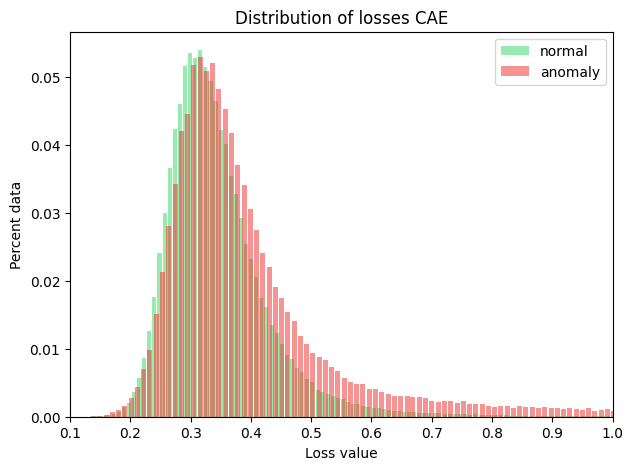

In [11]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = losses_normal_cae

# Get histogram
hist, bins = np.histogram(x, bins=1000)
hist = hist / np.sum(hist)

# Threshold frequency
freq = 0 #500

# Zero out low values
hist[np.where(hist <= freq)] = 0

# Plot
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.xlim([0,0.5])
#plt.margins(0.05)
plt.bar(center, hist, align='center', width=width, color = '#33D860', label='normal', alpha=0.5)#'#7eb54e')

##############################
# Plot Histogram on x
x = losses_anomaly_cae

# Get histogram
hist, bins = np.histogram(x, bins=1000)
hist = hist / np.sum(hist)

# Threshold frequency
freq = 0 #500

# Zero out low values
hist[np.where(hist <= freq)] = 0

# Plot
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.xlim([.1, 1.])
plt.bar(center, hist, align='center', width=width, color='#EF2B2B',label ='anomaly', alpha=0.5)#'#7eb54e') #FAAB9A'

plt.title("Distribution of losses CAE")
plt.xlabel("Loss value")
plt.ylabel("Percent data")
plt.legend();

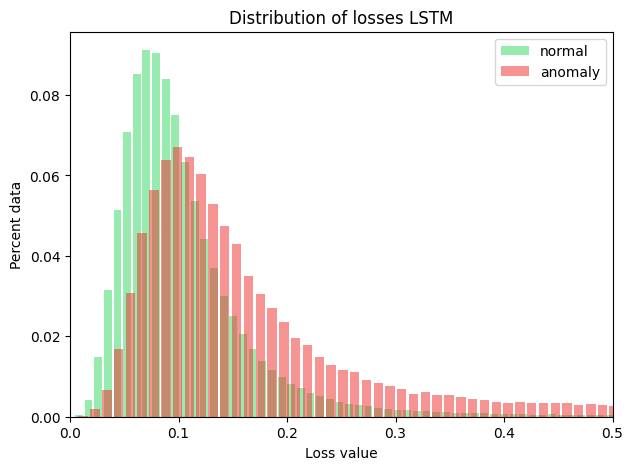

In [13]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = losses_normal_lstm

# Get histogram
hist, bins = np.histogram(x, bins=1000)
hist = hist / np.sum(hist)

# Threshold frequency
freq = 0 #500

# Zero out low values
hist[np.where(hist <= freq)] = 0

# Plot
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.xlim([0,0.5])
#plt.margins(0.05)
plt.bar(center, hist, align='center', width=width, color = '#33D860', label='normal', alpha=0.5)#'#7eb54e')

##############################
# Plot Histogram on x
x = losses_anomaly_lstm

# Get histogram
hist, bins = np.histogram(x, bins=1000)
hist = hist / np.sum(hist)

# Threshold frequency
freq = 0 # 500

# Zero out low values
hist[np.where(hist <= freq)] = 0

# Plot
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.xlim([0., .5])
plt.bar(center, hist, align='center', width=width, color='#EF2B2B',label ='anomaly', alpha=0.5)#'#7eb54e') #FAAB9A'

plt.title("Distribution of losses LSTM")
plt.xlabel("Loss value")
plt.ylabel("Percent data")
plt.legend();

## Latent vectors classification

### CAE

In [19]:
losses_anomaly_cae = losses_anomaly_cae.reshape(-1, 1)
losses_normal_cae = losses_normal_cae.reshape(-1, 1)

In [20]:
anomaly_df_cae = np.concatenate((features_anomaly_cae, losses_anomaly_cae, np.ones(losses_anomaly_cae.shape)), axis=1)
normal_df_cae = np.concatenate((features_normal_cae, losses_normal_cae, np.zeros(losses_normal_cae.shape)), axis=1)

In [21]:
df_learn_cae = np.concatenate((normal_df_cae, anomaly_df_cae), axis=0)
df_learn_cae = pd.DataFrame(df_learn_cae)
df_learn_cae[9] = df_learn_cae[9].astype(np.int32)
df_learn_cae.rename(columns={9: 'target'}, inplace=True)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    df_learn_cae[[0, 1, 2, 3, 4, 5, 6, 7, 8]],
    df_learn_cae['target'],
    test_size=.8,
    shuffle=True)

In [23]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

print(f'f1 for train - {f1_score(y_train, log_reg.predict(X_train))}')
print(f'f1 for test - {f1_score(y_test, log_reg.predict(X_test))}')

print(f'roc_auc for train - {roc_auc_score(y_train, log_reg.predict(X_train))}')
print(f'roc_auc for test - {roc_auc_score(y_test, log_reg.predict(X_test))}')

f1 for train - 0.14014611956072232
f1 for test - 0.137431613357245
roc_auc for train - 0.534980632549878
roc_auc for test - 0.5343871740630703


In [24]:
xgcl = XGBClassifier(n_estimators=600)
xgcl.fit(X_train, y_train)

print(f'f1 for train - {f1_score(y_train, xgcl.predict(X_train))}')
print(f'f1 for test - {f1_score(y_test, xgcl.predict(X_test))}')

print(f'roc_auc for train - {roc_auc_score(y_train, xgcl.predict(X_train))}')
print(f'roc_auc for test - {roc_auc_score(y_test, xgcl.predict(X_test))}')

f1 for train - 0.6285753765372392
f1 for test - 0.18810207531414838
roc_auc for train - 0.7297663157116927
roc_auc for test - 0.5419094519153416


### LSTM

In [36]:
losses_anomaly_lstm = losses_anomaly_lstm.reshape(-1, 1)
losses_normal_lstm = losses_normal_lstm.reshape(-1, 1)

In [37]:
anomaly_df_lstm = np.concatenate((features_anomaly_lstm, losses_anomaly_lstm, np.ones(losses_anomaly_lstm.shape)), axis=1)
normal_df_lstm = np.concatenate((features_normal_lstm, losses_normal_lstm, np.zeros(losses_normal_lstm.shape)), axis=1)

In [40]:
df_learn_lstm = np.concatenate((normal_df_lstm, anomaly_df_lstm), axis=0)
df_learn_lstm = pd.DataFrame(df_learn_lstm)
df_learn_lstm[5] = df_learn_lstm[5].astype(np.int32)
df_learn_lstm.rename(columns={5: 'target'}, inplace=True)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    df_learn_lstm[[0, 1, 2, 3, 4]],
    df_learn_lstm['target'],
    test_size=.8,
    shuffle=True)

In [42]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

print(f'f1 for train - {f1_score(y_train, log_reg.predict(X_train))}')
print(f'f1 for test - {f1_score(y_test, log_reg.predict(X_test))}')

print(f'roc_auc for train - {roc_auc_score(y_train, log_reg.predict(X_train))}')
print(f'roc_auc for test - {roc_auc_score(y_test, log_reg.predict(X_test))}')

f1 for train - 0.28838860647139514
f1 for test - 0.28935913546117115
roc_auc for train - 0.5805028002615304
roc_auc for test - 0.5808692135087038


In [43]:
xgcl = XGBClassifier(n_estimators=600)
xgcl.fit(X_train, y_train)

print(f'f1 for train - {f1_score(y_train, xgcl.predict(X_train))}')
print(f'f1 for test - {f1_score(y_test, xgcl.predict(X_test))}')

print(f'roc_auc for train - {roc_auc_score(y_train, xgcl.predict(X_train))}')
print(f'roc_auc for test - {roc_auc_score(y_test, xgcl.predict(X_test))}')

f1 for train - 0.6296847606761272
f1 for test - 0.35964086915994686
roc_auc for train - 0.7332875858571746
roc_auc for test - 0.604168207083497


## PCA

In [44]:
df_learn = np.concatenate((normal_df_lstm, anomaly_df_lstm), axis=0)
df_learn = pd.DataFrame(df_learn)
df_learn[5] = df_learn[5].astype(np.int32)
df_learn.rename(columns={5: 'target'}, inplace=True)

In [45]:
df_pca = df_learn

In [46]:
df_pca.head(20)

0         1         2         3         4  target
0   0.559570  0.260742 -0.258057  0.486572  0.068970       0
1   0.589844  0.296875 -0.127441  0.505859  0.085266       0
2   0.758789  0.088440 -0.036377  0.424805  0.144287       0
3   0.544922  0.198486 -0.292969  0.429688  0.136353       0
4   0.705566  0.077759 -0.260986  0.383545  0.126343       0
5   0.735352 -0.104065 -0.318359  0.270752  0.054596       0
6   0.841797 -0.190918 -0.243042  0.244751  0.099792       0
7   0.802734 -0.221924 -0.270996  0.206665  0.062286       0
8   0.634766  0.089905 -0.214722  0.354004  0.063538       0
9   0.786621 -0.101685 -0.266602  0.273926  0.050598       0
10  0.670898  0.036194 -0.215454  0.325928  0.072083       0
11  0.750000 -0.016403 -0.293457  0.322998  0.056183       0
12  0.655273  0.089050 -0.325195  0.373291  0.064453       0
13  0.604004  0.061707 -0.330811  0.332031  0.056732       0
14  0.687012 -0.032776 -0.325684  0.278809  0.084961       0
15  0.701172 -0.100952 -0.401367  0.254883  0.050568       0
16  0.654297  0.082458 -0.313721  0.382812  0.061401       0
17  0.749512  0.104248 -0.255371  0.445068  0.272705       0
18  0.795410  0.010529 -0.154785  0.372559  0.092102       0
19  0.696289  0.104980 -0.250000  0.441406  0.095154       0

In [47]:
pca = PCA(n_components=2)
feat_cols = ['0','1','2','3'] #,'4'] #with or without loss
feat_cols = [0,1,2,3,4]
pca_result = pca.fit_transform(df_pca[feat_cols].values)

df_pca['pca-one'] = pca_result[:,0]
df_pca['pca-two'] = pca_result[:,1] 
#df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.54120623 0.29803964]


<AxesSubplot: xlabel='pca-one', ylabel='pca-two'>

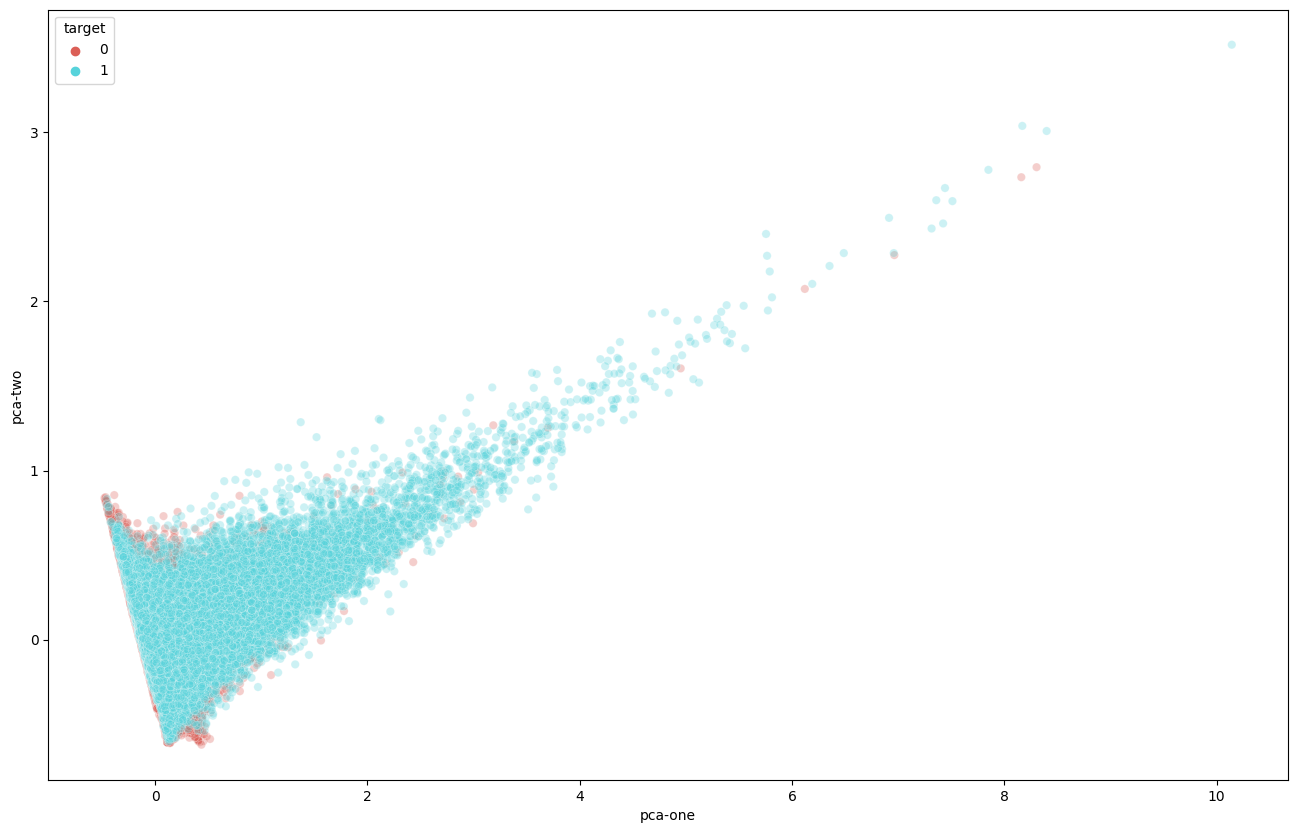

In [48]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

## Correlation between components

<AxesSubplot: xlabel='1', ylabel='2'>

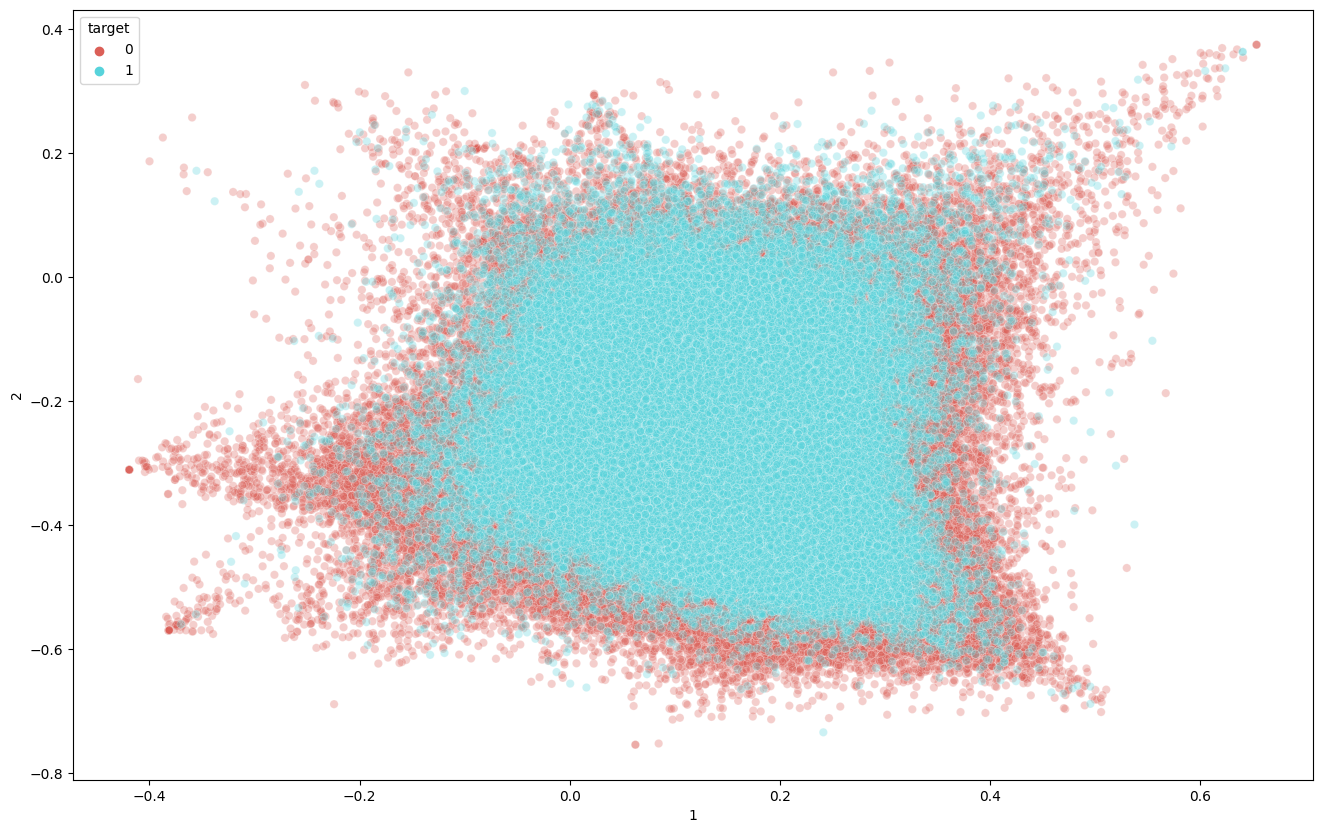

In [49]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=1, y=2, #print here names of columns
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca, #print here name of your dataframe
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='1', ylabel='3'>

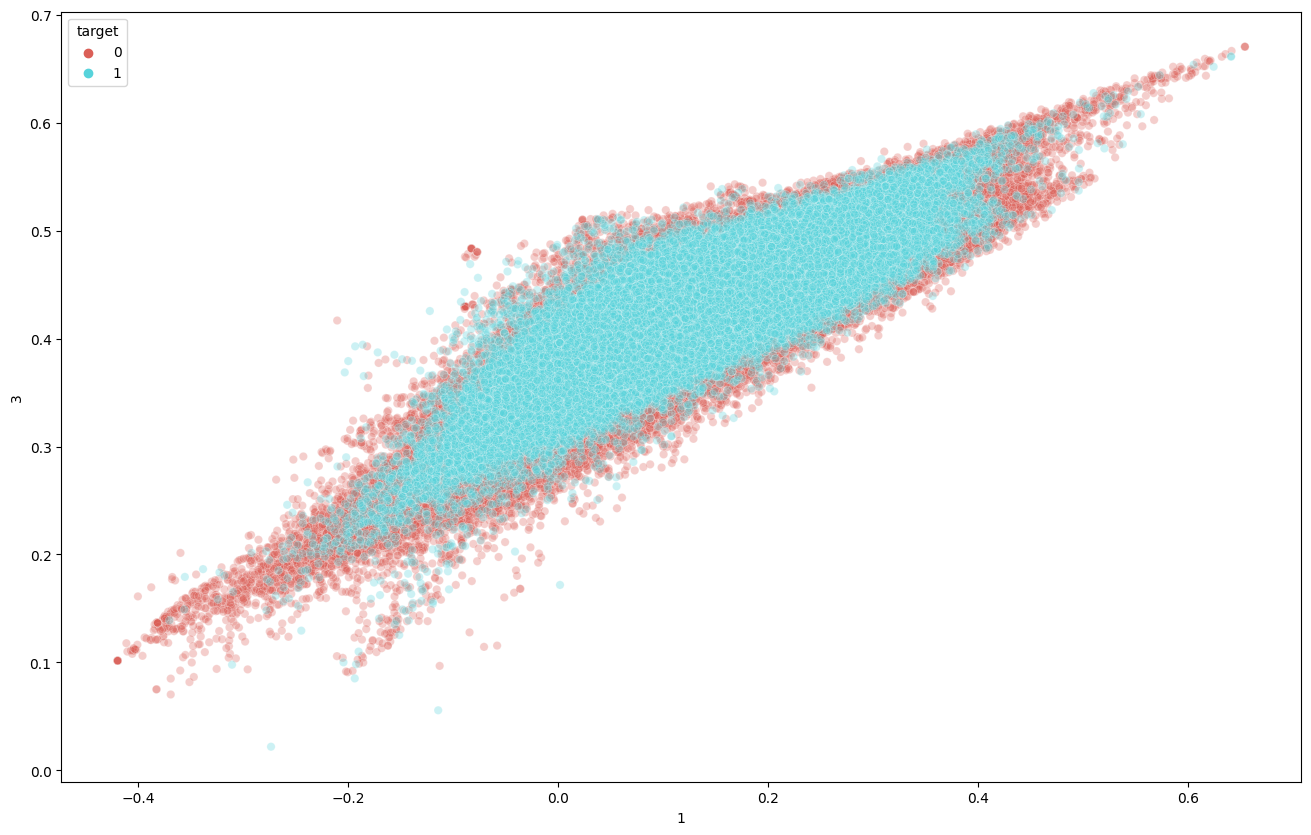

In [50]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=1, y=3,
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='1', ylabel='0'>

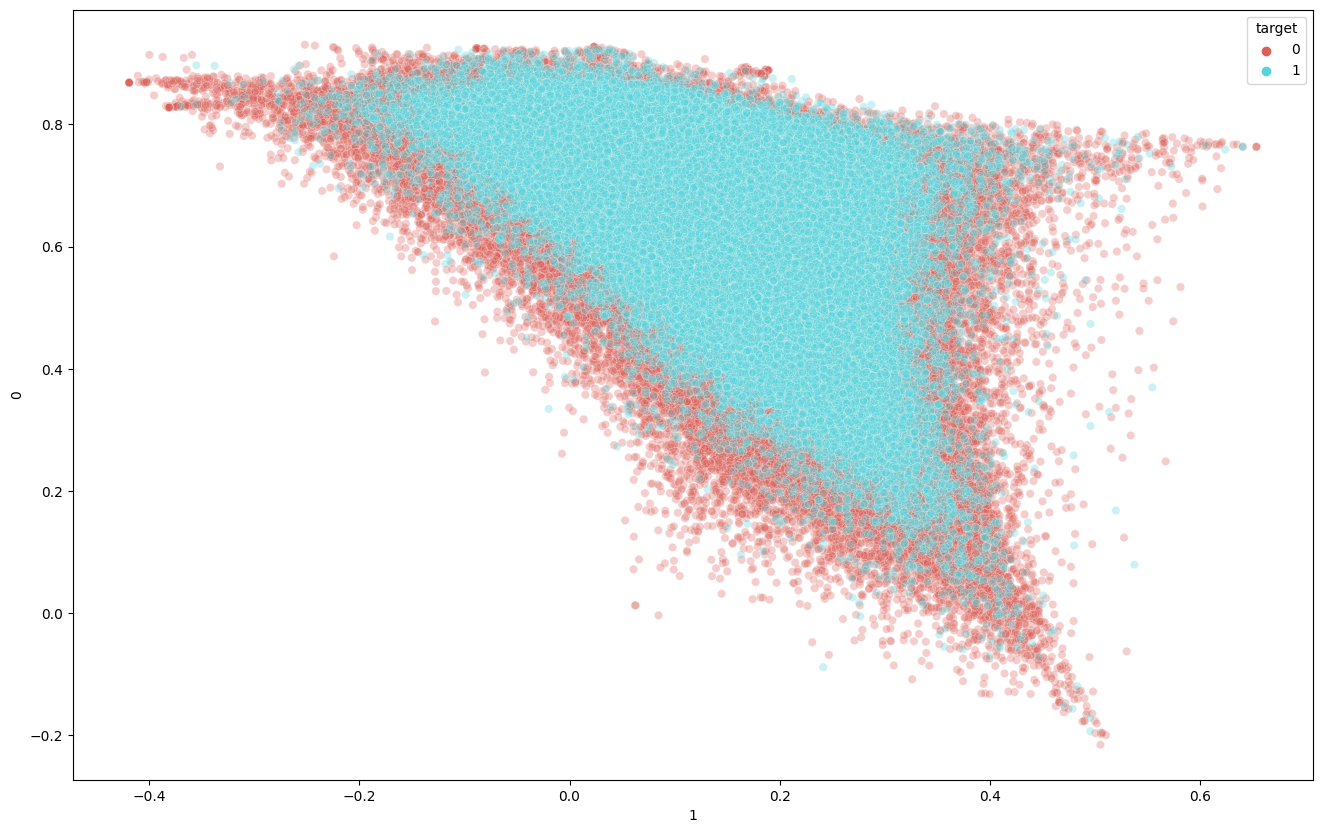

In [51]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=1, y=0,
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='1', ylabel='4'>

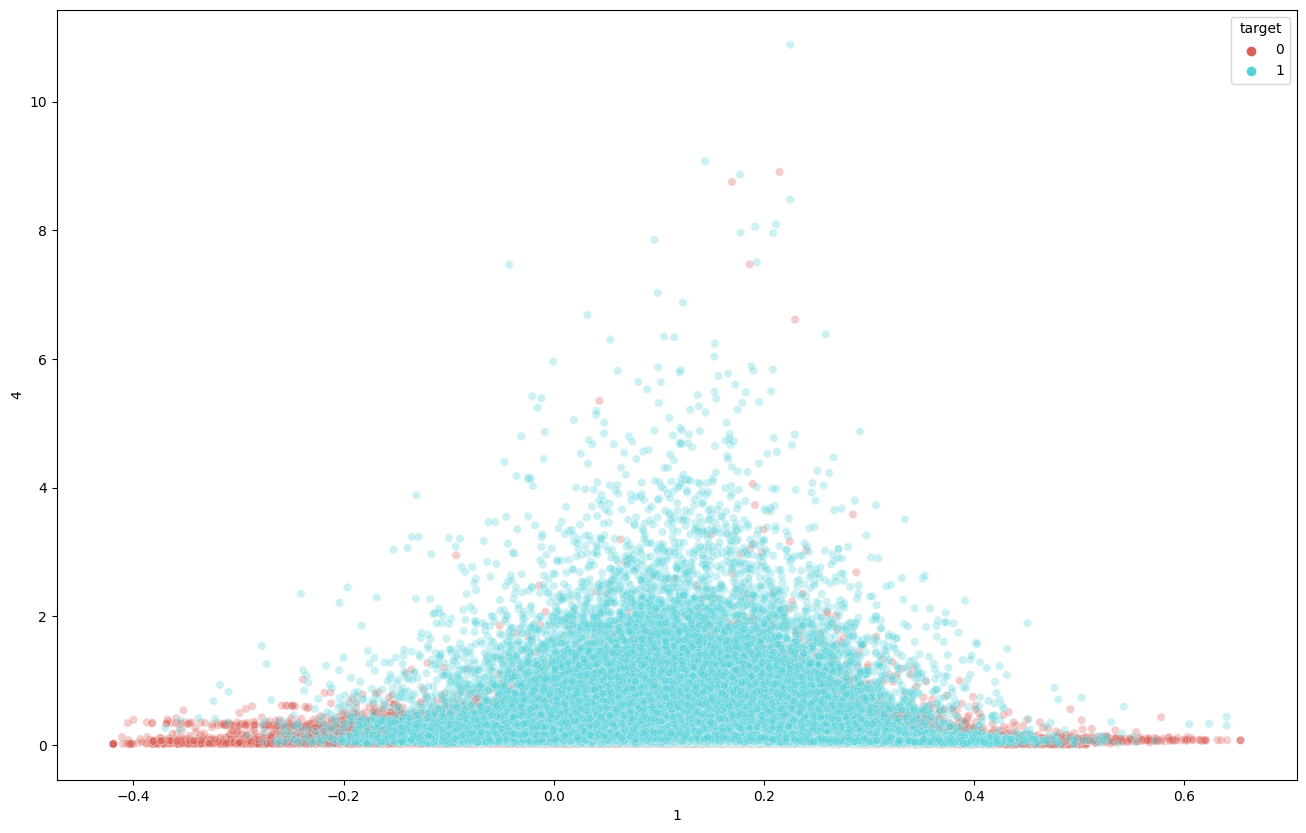

In [52]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=1, y=4,
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='0', ylabel='4'>

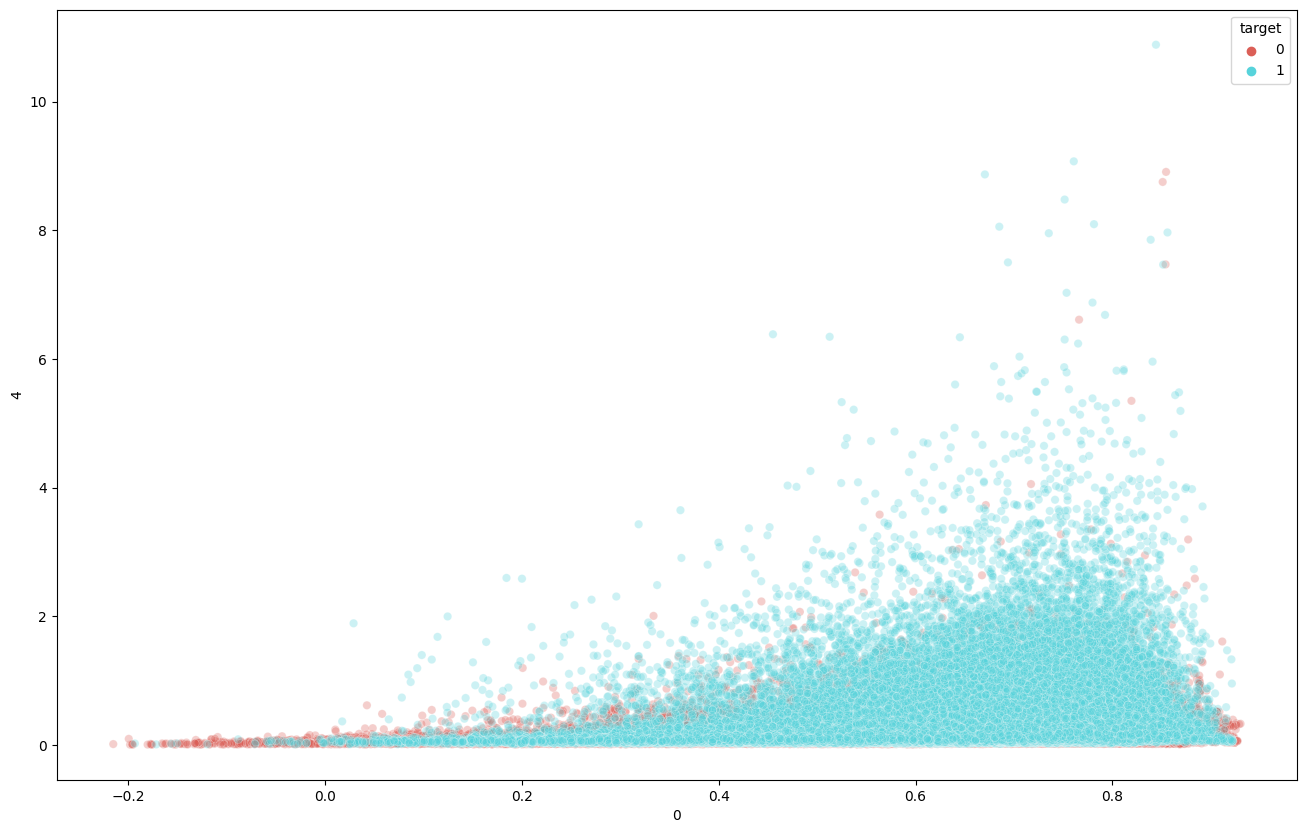

In [53]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=0, y=4,
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='0', ylabel='2'>

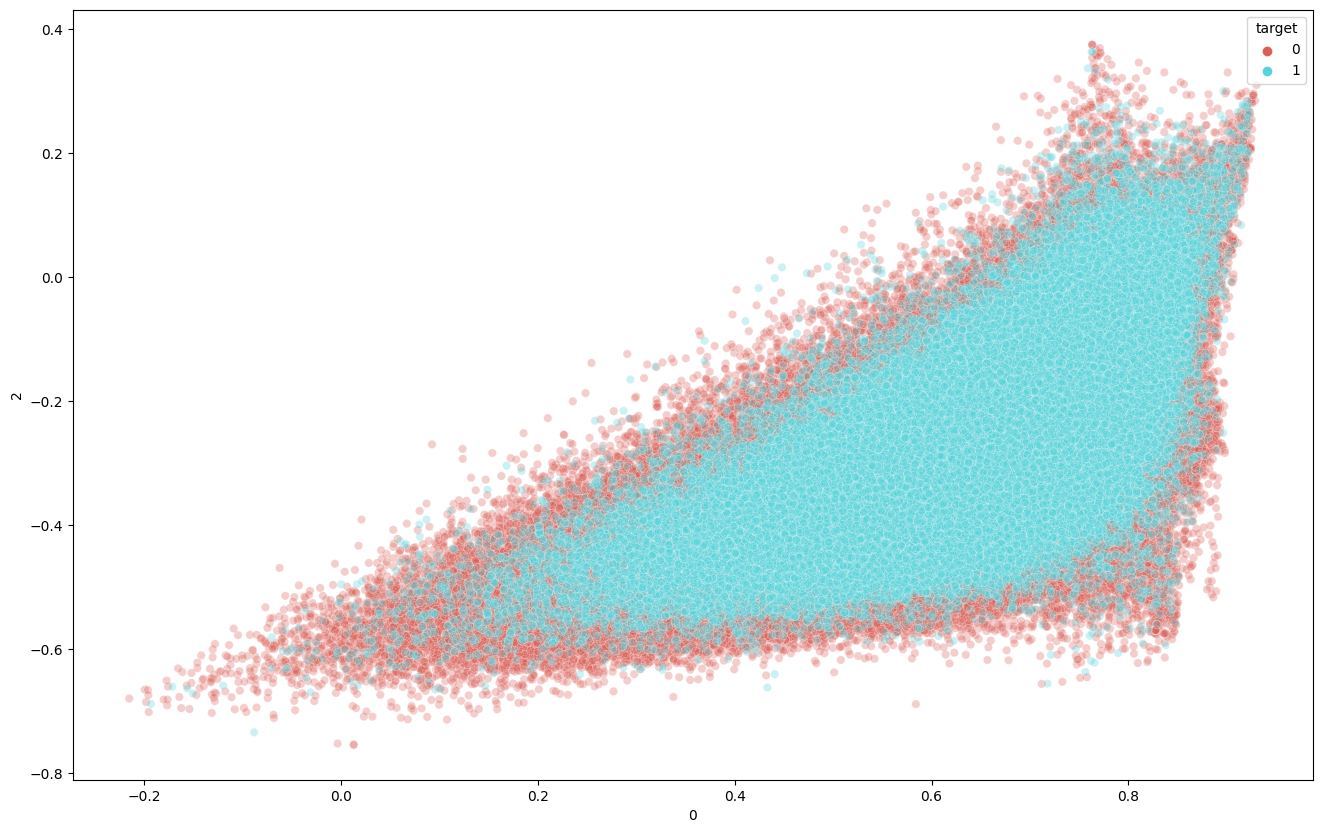

In [54]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=0, y=2,
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='0', ylabel='3'>

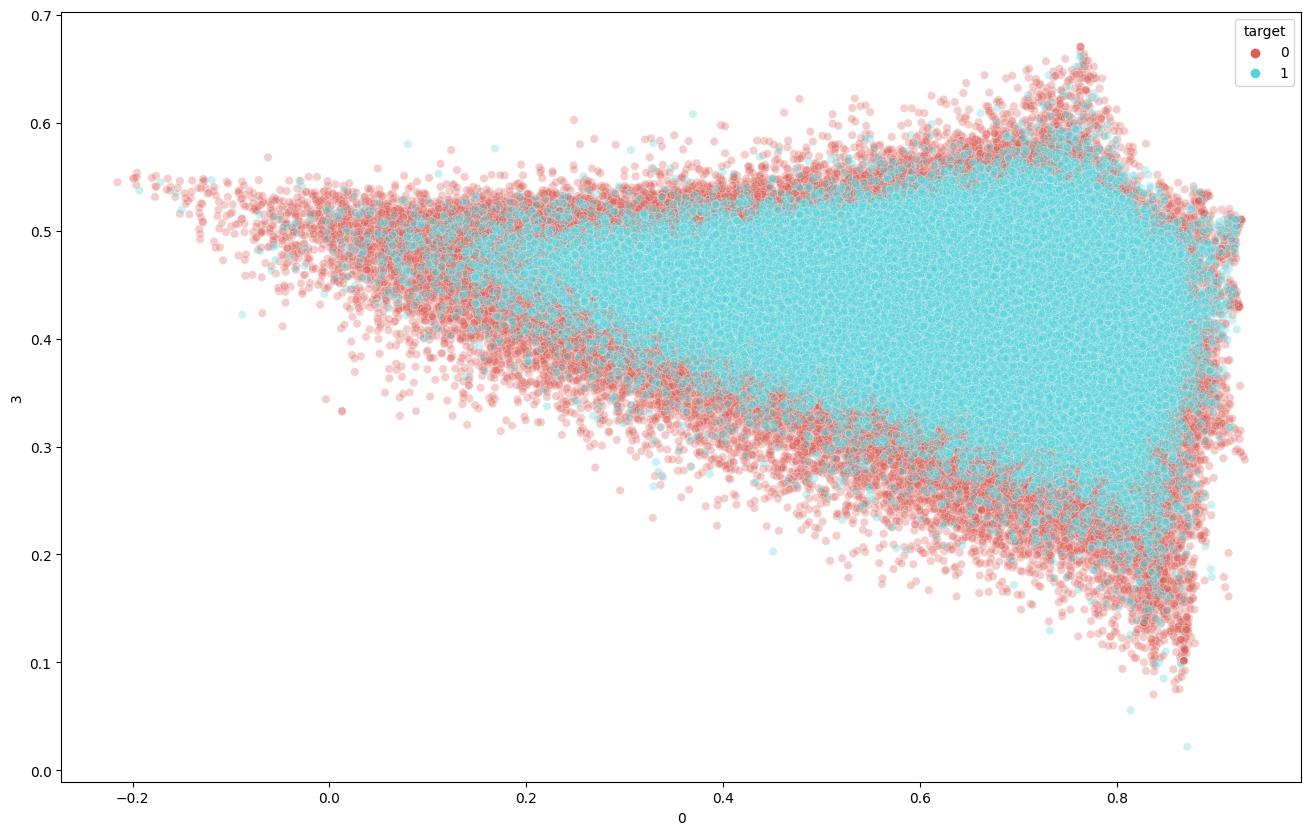

In [55]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=0, y=3,
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='2', ylabel='3'>

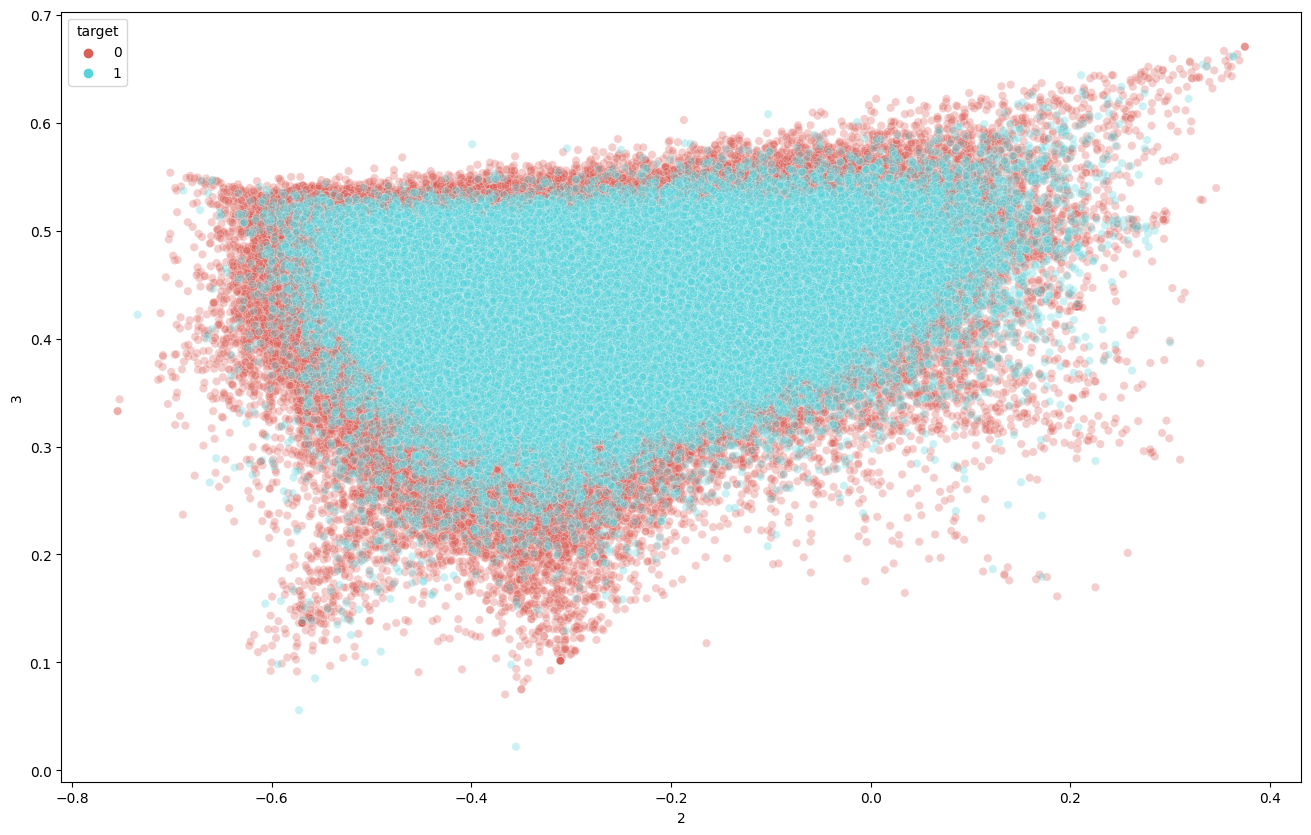

In [56]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=2, y=3,
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='2', ylabel='4'>

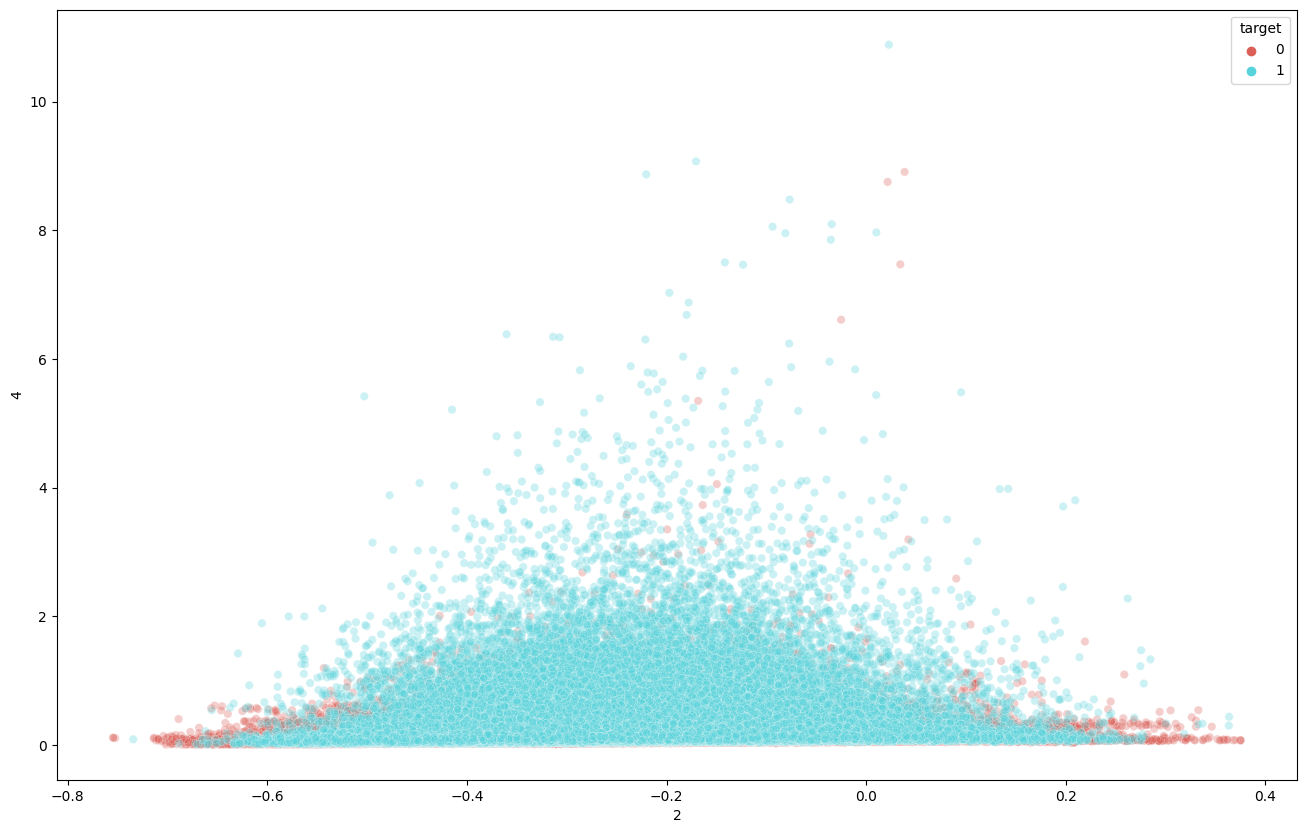

In [57]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=2, y=4,
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='3', ylabel='4'>

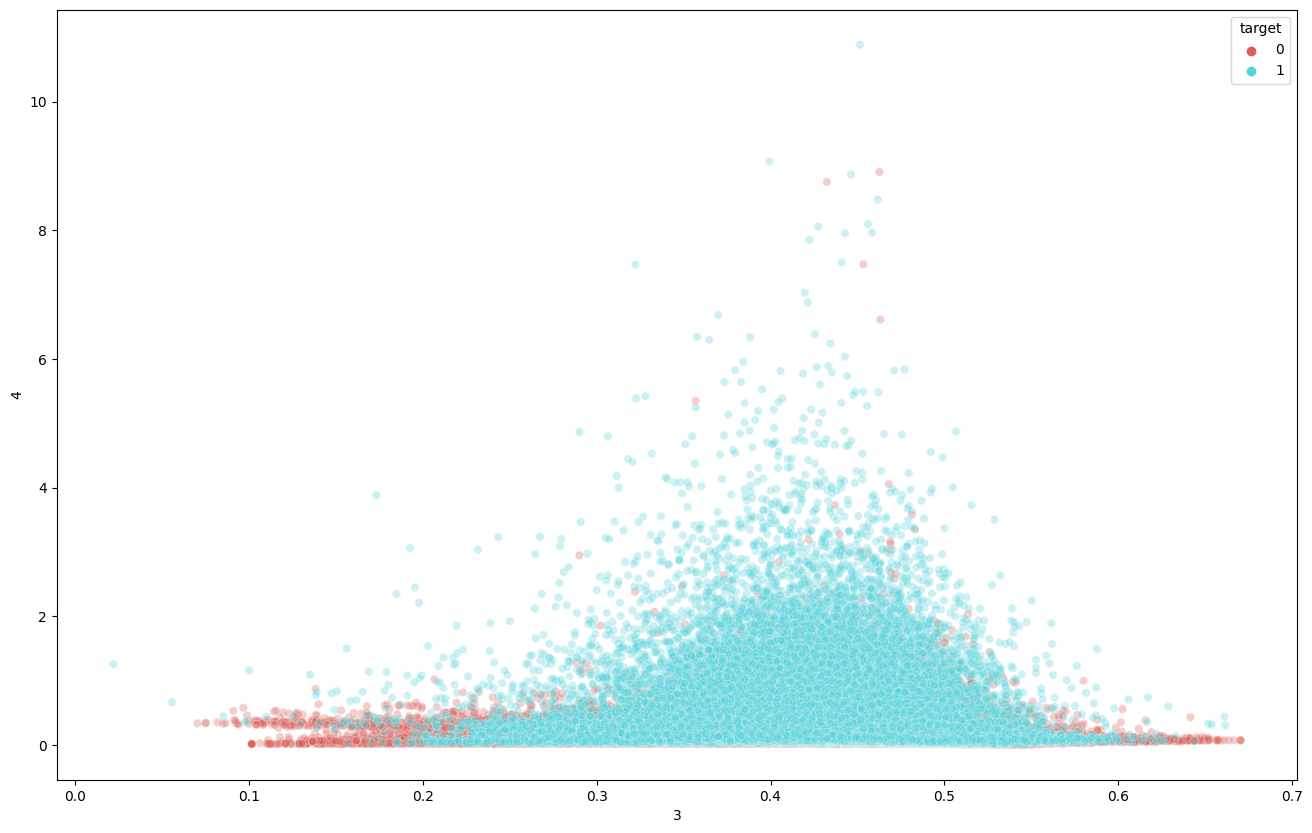

In [58]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=3, y=4,
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

## Training classifiers on PCA features

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    df_pca[[0, 1, 2, 3, 4 , 'pca-one','pca-two']],
    df_pca['target'],
    test_size=.8,
    shuffle=True)

In [60]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

print(f'f1 for train - {f1_score(y_train, log_reg.predict(X_train))}')
print(f'f1 for test - {f1_score(y_test, log_reg.predict(X_test))}')

print(f'roc_auc for train - {roc_auc_score(y_train, log_reg.predict(X_train))}')
print(f'roc_auc for test - {roc_auc_score(y_test, log_reg.predict(X_test))}')

c:\Users\artem\anaconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\artem\anaconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\artem\anaconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


f1 for train - 0.29224107107385483
f1 for test - 0.29100092566507024
roc_auc for train - 0.5817570500706867
roc_auc for test - 0.5814149103069202


c:\Users\artem\anaconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\artem\anaconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [61]:
xgcl = XGBClassifier(n_estimators=600)
xgcl.fit(X_train, y_train)

print(f'f1 for train - {f1_score(y_train, xgcl.predict(X_train))}')
print(f'f1 for test - {f1_score(y_test, xgcl.predict(X_test))}')

print(f'roc_auc for train - {roc_auc_score(y_train, xgcl.predict(X_train))}')
print(f'roc_auc for test - {roc_auc_score(y_test, xgcl.predict(X_test))}')

f1 for train - 0.6686452848252753
f1 for test - 0.3647632311977716
roc_auc for train - 0.7547027643835644
roc_auc for test - 0.6061296748312384
